In [ ]:
popularTags

In [ ]:
popularTags

# Analiza danych z DIY Stack Exchange

## Wstęp
Przed przystąpieniem do analizy danych zadaliśmy sobie następujące pytania:
- czy pandemia i tym samym przymus pozostawania w domu miał wpływ na zainteresowanie tematyką diy i lifehacków?
- jak zmieniał się poziom zaangażowania użytkowników w czasie?

## Analiza
### Importowanie bibliotek

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter

pd.set_option("display.notebook_repr_html", False)  # disable "rich" output
plt.style.use("seaborn")  # plot style

plt.rcParams.update({
    "font.size":         11,
    "figure.autolayout": True,
    "figure.dpi":        300,
    "figure.figsize":    (6, 3.5),  # default is [8.0, 5.5],
})

### Wczytanie danych

In [251]:
posts = pd.read_xml("diy/Posts.xml", parser = 'etree')
tags = pd.read_xml("diy/Tags.xml", parser = 'etree')

### 1. Liczba postów opublikowanych w danym kwartale

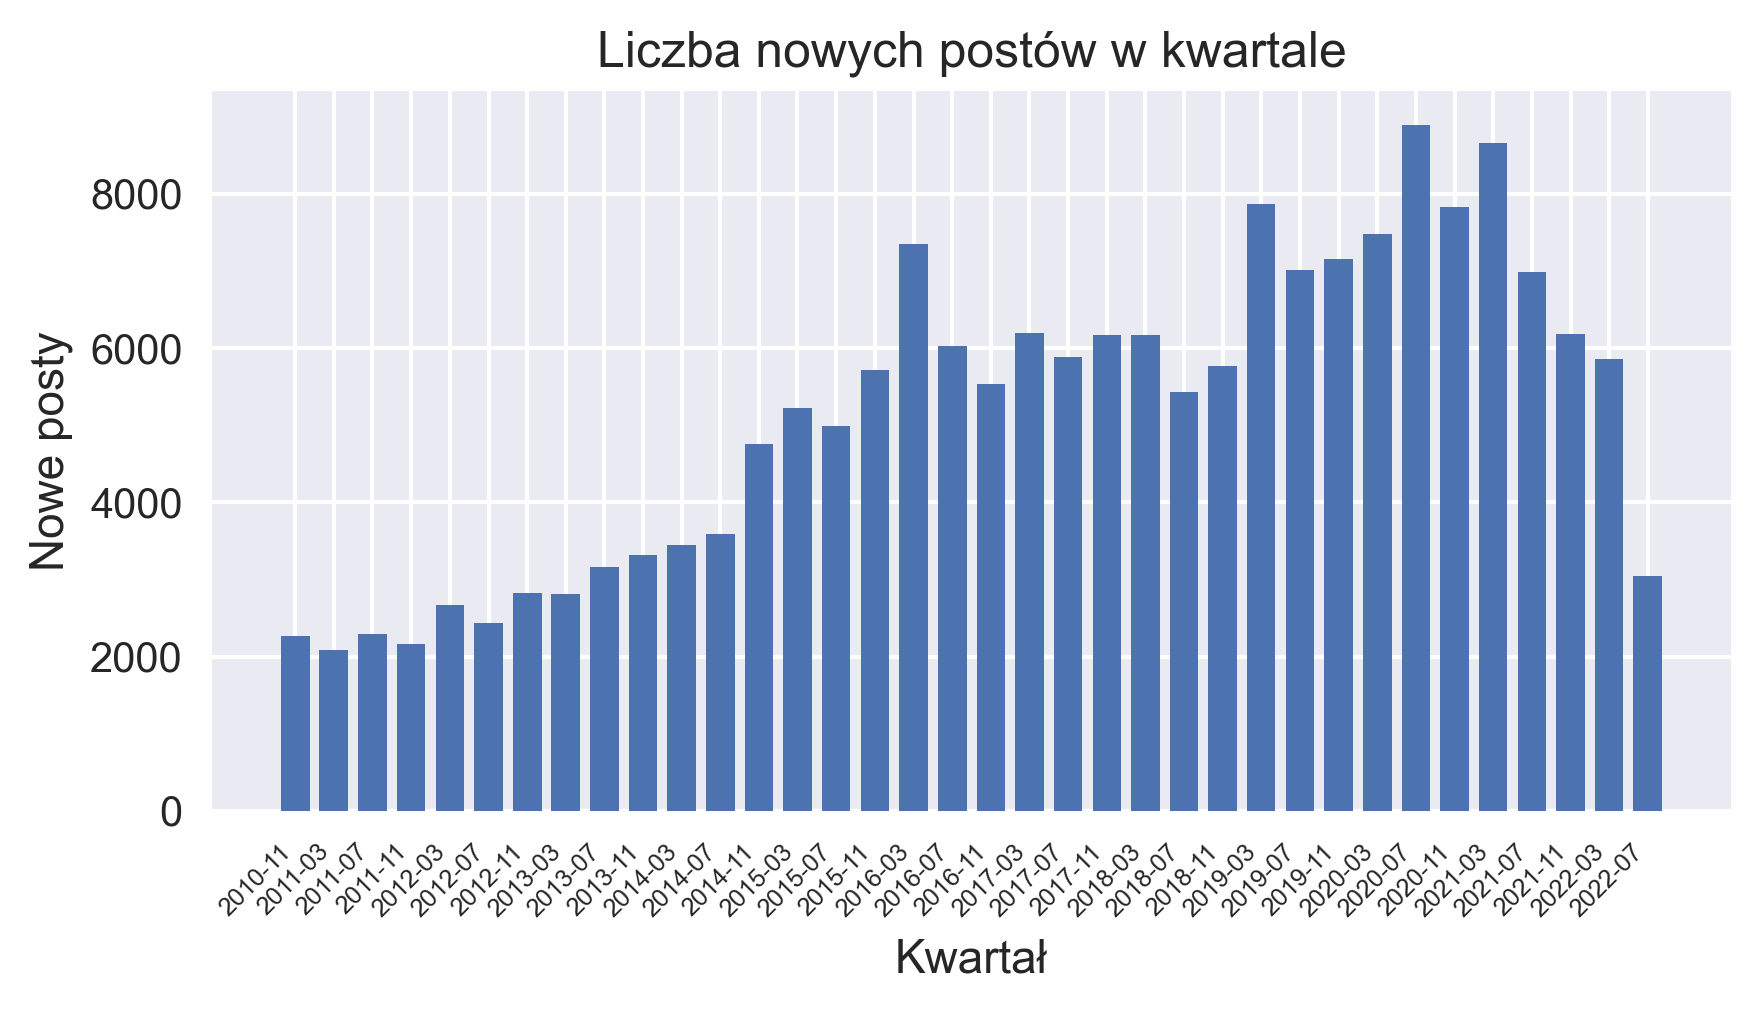

In [252]:
posts['CreationDateMonth'] = [datetime(int(date[0:4]), int(date[5:7]), 1) for date in posts.CreationDate]

grouped = posts.groupby(by=posts.CreationDateMonth)['Id'].count().reset_index()

grouped.rename(columns = {'CreationDateMonth':'Month', 'Id':'Count'}, inplace = True)
grouped.sort_values(by = "Month", ascending=True, inplace=True)

interval = grouped.resample('4m', on='Month').Count.sum()[1:].reset_index()

plt.bar(interval['Month'], interval['Count'], width = 90)
plt.xticks(interval['Month'], interval['Count'], rotation=45, fontsize='6', horizontalalignment='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Liczba nowych postów w kwartale')
plt.xlabel('Kwartał')
plt.ylabel('Nowe posty')
plt.show()

Jak można zauważyć, od marca 2020 do lipca 2021 roku jest zauważalny wzrost liczby publikowanych postów, może to wynikać z tego, że ludzie zmuszeni do pozostawania w domach szukali sposobów urozmaicania sobie czasu. Przyjrzyjmy się co mogło mieć wpływ na ten skok zainteresowania.

### Analiza tagów

In [253]:
popularTags = tags[ tags.Count > 500 ].sort_values(by=["Count"], ascending = False)
popularTags = popularTags['TagName'][:10].to_list()

In [257]:
def extractTag(tags):
    if pd.isna(tags):
        return ""
    for tag in popularTags:
        if tag in tags:
            return tag



posts["PopularTag"] = posts["Tags"].astype("string").apply(extractTag)
postsByTag = posts[(pd.isna(posts.PopularTag) == False) & (posts.PopularTag != "")]

## Cos